In [132]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
OUTPUT_DIR = "/data/patrick_res/glm"

session = 20180803
separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_separate.pickle"))
interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))

# interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_interaction.pickle"))
# shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_shuffles.pickle"))

In [134]:
stats = glm_utils.calculate_sig_stats(shuffled_res, 0.05, 15)

In [135]:
feedback_idxs = np.arange(13, 28, 1)
choice_idxs = np.arange(0, 13, 1)

In [136]:
stats = glm_utils.calculate_sig_stats(shuffled_res, 0.05, 15)
merged = pd.merge(interaction_res, stats, on=["UnitID", "TimeBins"])
# TODO: HACK!! make general solution here, get rid of TimeBins disaster
merged["TimeIdxs"] = (merged["TimeBins"] * 10).astype(int)
merged = merged[merged.TimeIdxs.isin(feedback_idxs)]
def assess_unit(unit_group):
    print(unit_group.TimeBins.unique())
    sig = unit_group.score > unit_group.sig_bound
    return pd.Series({"IsSig": np.any(sig)})


In [138]:
fb_units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, feedback_idxs)
choice_units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, choice_idxs)

In [126]:
len(fb_units_sig[fb_units_sig.IsSig])

30

In [127]:
fb_units_sig = fb_units_sig[fb_units_sig.IsSig]

In [128]:
pos = spike_utils.get_unit_positions_per_sess(session)
pos = spike_utils.get_manual_structure(pos)

In [ ]:
for unit in separate_res.UnitID.unique():
    fig, ax = plt.subplots()
    unit_pos = pos[pos.UnitID == unit].manual_structure.unique()[0]
    unit_separate = separate_res[separate_res.UnitID == unit].score
    unit_interaction = interaction_res[interaction_res.UnitID == unit].score
    sig_bound = stats[stats.UnitID == unit].sig_bound

    time_bins = interaction_res[interaction_res.UnitID == unit].TimeBins - 1.3

    ax.plot(time_bins, unit_separate, label="Separate Score")
    ax.plot(time_bins, unit_interaction, label="Interaction Score")
    ax.plot(time_bins, sig_bound, label="Significance Bound")

    ax.set_title(f"Unit {unit} ({unit_pos})")
    ax.legend()
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Fraction of Deviance Explained")

### Assess as a population, how many neurons fit this criteria

In [139]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [140]:
def find_sig_units_per_session(row, time_idxs, card=False):
    session = row.session_name
    if card: 
        interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_interaction.pickle"))
        shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_card_shuffles.pickle"))
    else: 
        interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_interaction.pickle"))
        shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    units_sig = glm_utils.identify_significant_units(interaction_res, shuffled_res, time_idxs)
    sig_units = units_sig[units_sig.IsSig]
    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)
    filtered_pos = pos[pos.UnitID.isin(sig_units.UnitID)]
    return filtered_pos

In [145]:
choice_card_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, choice_idxs, card=True), axis=1).values)
feedback_card_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, feedback_idxs, card=True), axis=1).values)
choice_rpe_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, choice_idxs, card=False), axis=1).values)
feedback_rpe_units = pd.concat(sessions.apply(lambda x: find_sig_units_per_session(x, feedback_idxs, card=False), axis=1).values)


In [147]:
print(len(choice_card_units))
print(len(feedback_card_units))
print(len(choice_rpe_units))
print(len(feedback_rpe_units))

190
154
311
523


In [148]:
feedback_rpe_units.to_pickle("/data/patrick_res/state_update_subpop.pickle")

<Axes: xlabel='manual_structure'>

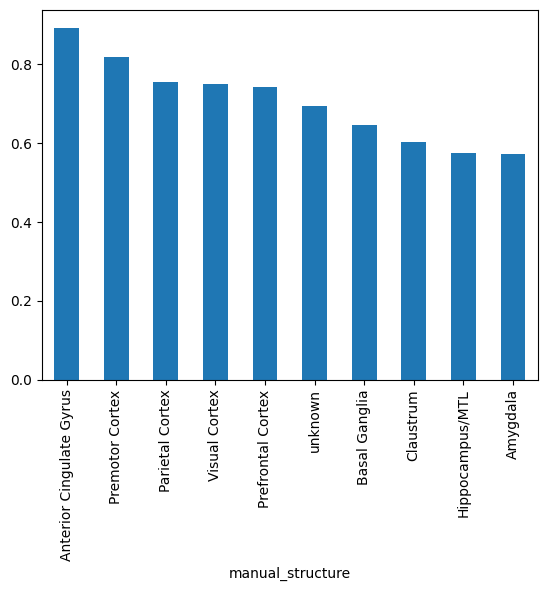

In [149]:
portions = spike_utils.get_subpop_ratios_by_region(feedback_rpe_units, sessions)
portions.Ratio.plot.bar()

<Axes: xlabel='manual_structure'>

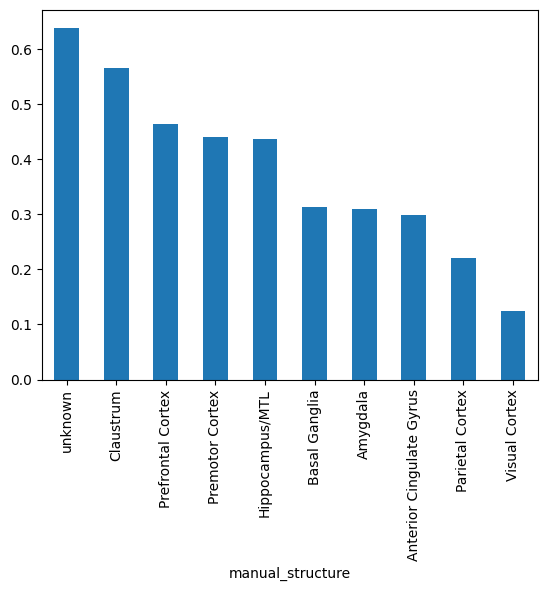

In [150]:
portions = spike_utils.get_subpop_ratios_by_region(choice_rpe_units, sessions)
portions.Ratio.plot.bar()

<Axes: xlabel='manual_structure'>

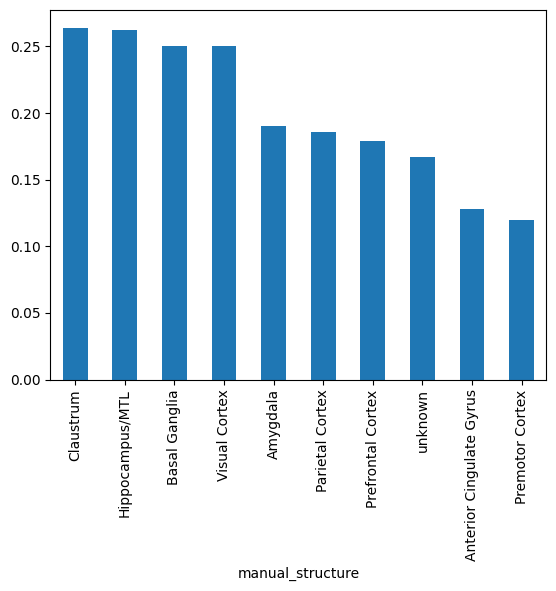

In [151]:
portions = spike_utils.get_subpop_ratios_by_region(feedback_card_units, sessions)
portions.Ratio.plot.bar()

<Axes: xlabel='manual_structure'>

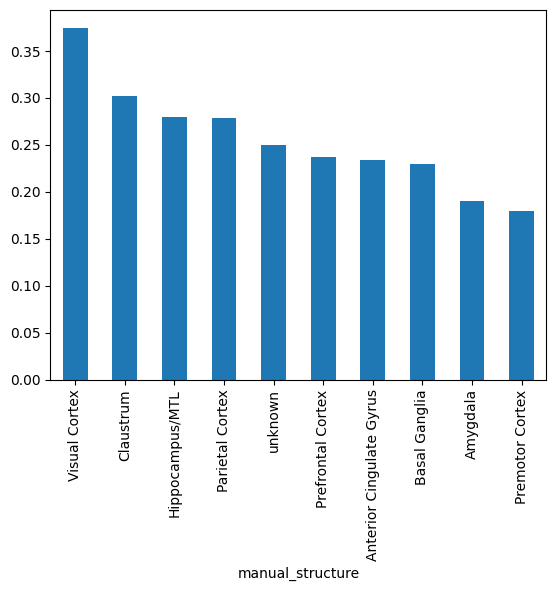

In [152]:
portions = spike_utils.get_subpop_ratios_by_region(choice_card_units, sessions)
portions.Ratio.plot.bar()

how many units are shared in rpe interaction selective pre feedback and postfeedback 

In [ ]:
shared_rpe_units = choice_rpe_units[choice_rpe_units.PseudoUnitID.isin(feedback_rpe_units.PseudoUnitID)]

In [ ]:
len(shared_rpe_units)

In [ ]:
card_rpe_fb_units = feedback_card_units[feedback_card_units.PseudoUnitID.isin(feedback_rpe_units.PseudoUnitID)]

In [ ]:
len(card_rpe_fb_units)

In [ ]:
card_rpe_choice_units = choice_card_units[choice_card_units.PseudoUnitID.isin(choice_rpe_units.PseudoUnitID)]

In [ ]:
len(card_rpe_choice_units)